In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import joblib
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import shap
print(shap.__version__)

0.50.0


In [ ]:
# Load the feature-engineered dataset
df = pd.read_csv(r"..data\processed_data\bank_of_canada_feature_engineered.csv")

In [ ]:

# Drop non-numeric columns (except target)
feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()

In [27]:
# Remove target columns from features if present
feature_cols = [c for c in feature_cols if c not in ['risk_score']]
X = df[feature_cols]

In [ ]:
 #For 3-class target
if 'credit_risk' not in df.columns:
    # Recreate target
    df['credit_risk'] = pd.qcut(df['risk_score'], q=3, labels=['Low','Medium','High'])

In [ ]:
# For small dataset, converting to binary to avoid single-class fold issues
df['credit_risk_binary'] = df['credit_risk'].replace({'Medium':'High'})  # Low vs High
le = LabelEncoder()
y = le.fit_transform(df['credit_risk_binary'])  # 0 = Low, 1 = High

In [ ]:
print("Class distribution:", pd.Series(y).value_counts())

Class distribution: 0    3
1    2
Name: count, dtype: int64


In [ ]:
# STEP 4: Initialize model
# -----------------------------
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# STEP 5: Splitting data safely
# -----------------------------
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)  # only 2 folds
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

              precision    recall  f1-score   support

        High       0.67      1.00      0.80         2
         Low       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3

              precision    recall  f1-score   support

        High       0.50      1.00      0.67         1
         Low       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



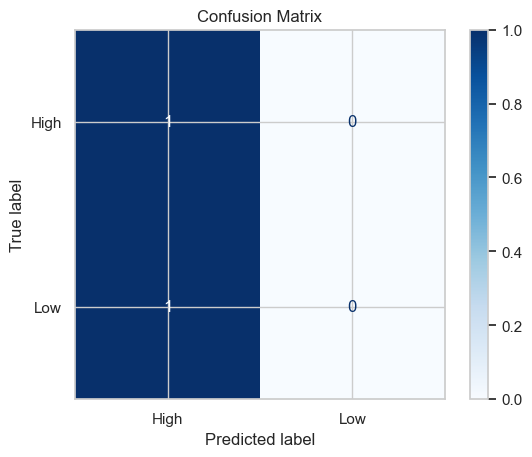

In [34]:
# STEP 6: Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [ ]:
shap.summary_plot(
    shap_values[1],   # class = High Risk
    X,
    feature_names=X.columns
)

In [ ]:
type(shap_values), np.array(shap_values).shape

(numpy.ndarray, (5, 19, 2))

In [ ]:
print(len(shap_values))  # if it's a list

5


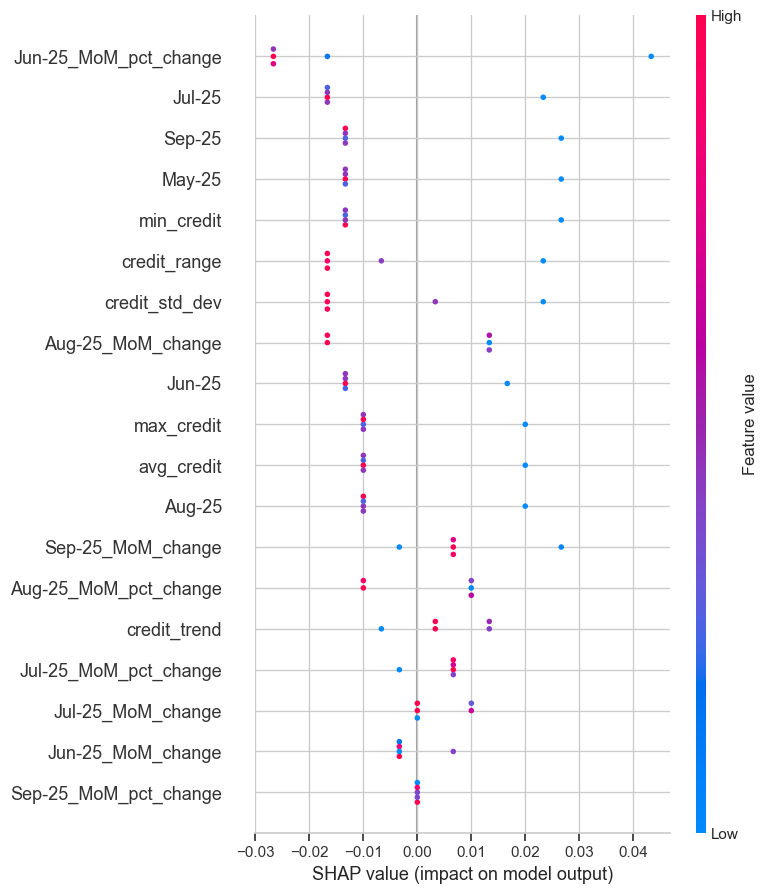

In [ ]:
shap.summary_plot(
    shap_values[:, :, 1],  # High-risk class
    X
)